# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [27]:
from datetime import date
import time
import scipy.io as sio
import anndata
import loompy
import pandas as pd
import numpy as np
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
# !pip -q install numdifftools 
# !pip -q install parfor
# !pip -q install loompy
# !pip -q install gdown
# !pip -q install bustools

     |████████████████████████████████| 99 kB 4.3 MB/s 
     |████████████████████████████████| 189 kB 38.7 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts.

In [4]:
!git clone https://github.com/tarachari3/GP_2021_3.git

fatal: destination path 'seq-cme-technoise' already exists and is not an empty directory.


In [5]:
!mv GP_2021_3/* .
#!rm -r seq-cme-technoise

In [6]:
!mv polyA_ref/* .

Download SMART-seq3 Mouse fibroblast data from https://github.com/Yenaled/smart-seq3/

In [4]:
!gdown https://drive.google.com/uc?id=1NvxnpIMIa1gQQft6-cBnYev-iWGMSuSr
!unzip -o mouse_velocity_processed_BUS.zip -d output_mouse
!rm mouse_velocity_processed_BUS.zip

Downloading...
From: https://drive.google.com/uc?id=1NvxnpIMIa1gQQft6-cBnYev-iWGMSuSr
To: /home/tchari/perturbCME/notebooks/mouse_velocity_processed_BUS.zip
100%|██████████████████████████████████████| 2.03G/2.03G [00:36<00:00, 55.5MB/s]
Archive:  mouse_velocity_processed_BUS.zip
  inflating: output_mouse/flens.txt  
  inflating: output_mouse/index.saved  
  inflating: output_mouse/matrix.ec  
  inflating: output_mouse/output_internal.spliced.unfiltered.bus  
  inflating: output_mouse/output_internal.unspliced.unfiltered.bus  
  inflating: output_mouse/output_umi.spliced.unfiltered.bus  
  inflating: output_mouse/output_umi.unspliced.unfiltered.bus  
  inflating: output_mouse/run_info.json  
  inflating: output_mouse/t2g.txt    
  inflating: output_mouse/transcripts.txt  


Count UMIs (make loom object Spliced and Unspliced)

In [5]:
%%time
!/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/kb_python/bins/linux/bustools/bustools count --umi-gene --genecounts -o counts_mouse_umi_spliced/ -g output_mouse/t2g.txt -e output_mouse/matrix.ec -t output_mouse/transcripts.txt output_mouse/output_umi.spliced.unfiltered.bus
!/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/kb_python/bins/linux/bustools/bustools count --umi-gene --genecounts -o counts_mouse_umi_unspliced/ -g output_mouse/t2g.txt -e output_mouse/matrix.ec -t output_mouse/transcripts.txt output_mouse/output_umi.unspliced.unfiltered.bus

CPU times: user 1.3 s, sys: 284 ms, total: 1.58 s
Wall time: 2min


In [59]:
#Spliced matrix
counts_dir = "counts_mouse_umi_spliced/"
matrix_path=counts_dir+"output.mtx"
barcodes_path=counts_dir+"output.barcodes.txt"
genes_path=counts_dir+"output.genes.txt"

matS = sio.mmread(matrix_path)

In [60]:
counts_dir = "counts_mouse_umi_unspliced/"
matrix_path=counts_dir+"output.mtx"
barcodes_path=counts_dir+"output.barcodes.txt"
genes_path=counts_dir+"output.genes.txt"

matU = sio.mmread(matrix_path)

In [61]:
!mkdir /home/tchari/counts/smartseq3_fibro/loom

mkdir: cannot create directory ‘/home/tchari/counts/smartseq3_fibro/loom’: File exists


In [62]:
barcodes = pd.read_csv(barcodes_path,sep=' ',header=None)
barcodes.head()

,0
0,AAGAGACGAACCGCAA
1,AAGAGACGAATGCGGA
2,AAGAGACGACAGTGGA
3,AAGAGACGACCTCACA
4,AAGAGACGCCAACCAA


In [63]:
names = pd.read_csv(genes_path,sep=' ',header=None)
names.head()

,0
0,ENSMUSG00000026535.9
1,ENSMUSG00000026315.13
2,ENSMUSG00000000817.10
3,ENSMUSG00000063558.4
4,ENSMUSG00000001138.13


In [43]:
# #Remove Ensembl version
# names[0] = names[0].str.split('.').str[0]

In [64]:
t2g = pd.read_csv("output_mouse/t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t", usecols=[0,1,2])
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

t2g.head()

,tid,gene_id,gene_name
gene_id,,,
ENSMUSG00000026535.9,ENSMUST00000000266.8,ENSMUSG00000026535.9,Ifi202b
ENSMUSG00000026315.13,ENSMUST00000000514.10,ENSMUSG00000026315.13,Serpinb8
ENSMUSG00000000817.10,ENSMUST00000000834.3,ENSMUSG00000000817.10,Fasl
ENSMUSG00000063558.4,ENSMUST00000001027.6,ENSMUSG00000063558.4,Aox1
ENSMUSG00000001138.13,ENSMUST00000001166.13,ENSMUSG00000001138.13,Cnnm3


In [65]:
#Map to gene names, instead of ids, to match reference
gene_names = names[0].map(t2g["gene_name"])

In [67]:
fname = '/home/tchari/counts/smartseq3_fibro/loom/smartSeq3Fibro.loom'  


		#row_attrs = { "Gene": geneNames } #genes
		#col_attrs = { "Barcode": np.array(barcodes) } #cells

retAdata = anndata.AnnData(
	X=matS,
	layers={
		'spliced': matS,
		'unspliced': matU
	},
	obs=pd.DataFrame({'barcode': np.array(barcodes[0])},index=np.array(np.array(barcodes[0]))),
	var=pd.DataFrame({'gene_name': np.array(np.array(gene_names))},index=np.array(np.array(gene_names)))
)

retAdata.write_loom(fname)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
# Can add this function later to seq_cme_inference
# Write input txt file

def genRunInput(fname='example_input.txt',dataDir = './',outDir='./',loomName = '',tranName = '',polyaA='15',tInd='0',
                filt='0.01, 0.01, 350, 350, 3, 3',exclude='',attList="[['spliced','unspliced','Gene','Barcode']]",
                seed='42', nGenes='5000', ind='0', gList='', lb='-2, -1.8, -1.8', ub='4.2, 2.5, 2.5',
                restart='1',init='moments',length='True',niter='20',nCu='10',nlambda='11',
                lbSamp='-9, -4',ubSamp='-4, 1.5',suffix='1',creator='tc',ncor='20',override=''):
    '''
    Generate run file for CME inference procedure. 
    Parameters listed in order of appearance in run text file.
    For a dry-run set ind = '-1'.

    Parameters:
    fname: filepath for run file
    dataDir: filepath for data directory
    outDir: filepath for output directory
    loomName: loom filenames
    tranName: transcriptome filepath
    polyaA: min polyA count
    tInd: column of transcriptome file (lengths if 0, polyA count if 1)
    filt: min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
    exclude:  result files (with genes to exclude)
    attList: list of lists for loom attribute names
    seed: gene selection seed
    nGenes: number of genes to select
    ind: loom file to analyze
    gList: result files to use for gene names
    lb: log10 of lower bound on burst size, splice rate, degradation rate
    ub: upper bound on on burst size, splice rate, degradation rate
    restart: how many times to run the search for each gene
    init: method to start search; 'random' if nothing
    length: use gene length for Poisson sampling
    niter: max iterations of gradient descent
    nCu: number of C_u points to evaluate
    nlambda: number of lambda_s points to evalute
    lbSamp: lower limits of C_u and lambda_s
    ubSamp: upper limits of C_u and lambda_s
    suffix: folder directory suffix
    creator: directory creator name
    ncor: number of cores to use
    override: if empty, use today's date from computer, else use string provided

    Returns:
    Run file (txt)
    '''

    with open(fname, 'w') as f:
        f.write('#Parameter input for CME inference ')
        f.write('\n')
        f.write('dataset_directory : '+dataDir+' : folder with dataset loom files')
        f.write('\n')
        f.write('result_directory : '+outDir+' : where to put the result folder')
        f.write('\n')
        f.write('loom_filenames : '+loomName+' : filenames to integrate')
        f.write('\n')
        f.write('transcriptome_filename : '+tranName+' : transcriptome location')
        f.write('\n')
        f.write('polyA_threshold : '+polyaA+' : minimum polyA count to use for sampling function')
        f.write('\n')
        f.write('transcriptome_ind : '+tInd+' : column of transcriptome file to use (lengths if 0, polyA count if 1)')
        f.write('\n')
        f.write('filter_param : '+filt+' : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S')
        f.write('\n')
        f.write('all_prev_results : '+exclude+': result files with gene names to exclude')
        f.write('\n')
        f.write('attribute_names : '+attList+' : list or list of lists with loom attribute names')
        f.write('\n')
        f.write('gene_sel_seed : '+seed+' : gene selection seed')
        f.write('\n')
        f.write('n_gen : '+nGenes+' : number of genes to select')
        f.write('\n')
        f.write('IND : '+ind+' : loom_filename to analyze')
        f.write('\n')
        f.write('gene_list : '+gList+' : set of result files to import to define gene names')
        f.write('\n')
        f.write('phys_lb : '+lb+' : log10 of lower bound on burst size, splice rate, degradation rate')
        f.write('\n')
        f.write('phys_ub : '+ub+' : upper bound on same')
        f.write('\n')
        f.write('search_restarts : '+restart+' : how many times to run the search for each gene')
        f.write('\n')
        f.write("init_pattern : "+init+" : whether to start the search using method of moments estimate or not; 'random' if not")
        f.write('\n')
        f.write('use_lengths : '+length+' : whether the Poisson sampling for unspliced mRNA should depend on gene length')
        f.write('\n')
        f.write('maxiter : '+niter+' : number of iterations of gradient descent to perform')
        f.write('\n')
        f.write('n_pt1 : '+nCu+' : number of C_u points to evaluate')
        f.write('\n')
        f.write('n_pt2 : '+nlambda+' : number of lambda_s points to evalute')
        f.write('\n')
        f.write('samp_lb : '+lbSamp+' : lower limits of C_u and lambda_s')
        f.write('\n')
        f.write('samp_ub : '+ubSamp+' : upper limits of C_u and lambda_s')
        f.write('\n')
        f.write('ID_suffix : '+suffix+' : folder directory suffix')
        f.write('\n')
        f.write('creator : '+creator+' : directory creator name, can also be used for generic metadata')
        f.write('\n')
        f.write('NCOR : '+ncor+' : number of cores to use')
        f.write('\n')
        f.write("date_override : "+override+": if empty, use today's date from computer. if not, use the given string")




In [69]:
# a e s t h e t i c s

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

In [70]:
def import_precomputed_(filestring):
    #Import result.pickle file
    with open(filestring,'rb') as f:
        precomp = pickle.load(f)
    return precomp

def check_at_bounds(result_data,phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        result_data.search_params.lb_log+thr > phys_params,
        result_data.search_params.ub_log-thr < phys_params) ,1)
    return x

def get_name(fname,iden="_20x21"):
    #Get all result files for run
    start = fname.find(data_path+proj_fold+out_fold+creator+'_'+override+'_') + len(data_path+proj_fold+out_fold+creator+'_'+override+'_')
    end = fname.find(iden)
    substring = fname[start:end]
    
    return substring

## Inference

Import the processing scripts.

In [71]:
from seq_cme_inference import *
from driver import *
from itertools import combinations
from matplotlib.colors import ListedColormap
import glob
import numpy as np
import pandas as pd
import seaborn as sns

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [49]:
#Generate example run script for driver functions
#For dry-run set loom file index (IND) to -1

genRunInput() # Generate example_input.txt 
!cat example_input.txt 

#Parameter input for CME inference 
dataset_directory : ./ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames :  : filenames to integrate
transcriptome_filename :  : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result files to import to define gene names
phys_lb : -2, -1.8, -1.8 : log10 of lower bound on burst size, splice rate, degradation rate
phys_ub : 4

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

### **Set global variables**

In [72]:
data_path = '/home/tchari/counts/'

in_fold = 'loom/'
out_fold = 'loom_res/'

transcriptome = 'gg_200524_mouse_genome_polyA_cum_1'

#Dataset-dependent

# Only use neg control samples with >500 cells
smartseq_looms = ['smartSeq3Fibro']  #Maybe change to sgHUS1_2a_sgFDPS_2b, sgNegCtrl02093a_sgFDPS_2b

proj_fold = 'smartseq3_fibro/'   

override='220526' #'220324'


creator = 'tc'

In [74]:
selGenes = creator+'_'+override+'_selected_genes.csv'
filtGenes = creator+'_'+override+'_filtered_genes.csv'

In [52]:
# selGenesErr = creator+'_'+overrideErr+'_selected_genes.csv'
# filtGenesErr = creator+'_'+overrideErr+'_filtered_genes.csv'

In [37]:
!mkdir {data_path+proj_fold+out_fold}

mkdir: cannot create directory ‘/home/tchari/counts/smartseq3_fibro/loom_res/’: File exists


### **Conduct gene selection and sampling parameter fitting across a set of combined Negative Controls**
Selected negative controls with >500 cells 

In [ ]:
# fname='example_input.txt',dataDir = './',outDir='./',loomName = '',tranName = '',polyaA='15',tInd='0',
#                 filt='0.01, 0.01, 350, 350, 3, 3',exclude='',attList="[['spliced','unspliced','Gene','Barcode']]",
#                 seed='42', nGenes='5000', ind='0', gList='', lb='-2, -1.8, -1.8', ub='4.2, 2.5, 2.5',
#                 restart='1',init='moments',length='True',niter='20',nCu='10',nlambda='11',
#                 lbSamp='-9, -4',ubSamp='-4, 1.5',suffix='1',creator='tc',ncor='20',override=''

In [75]:
genRunInput(fname=smartseq_looms[0]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
            outDir=data_path+proj_fold+out_fold,loomName = smartseq_looms[0],nCu='20',nlambda='21',
            restart='5', niter='40',
            attList= "[['spliced','unspliced','gene_name','barcode']]", tranName = transcriptome,override=override)

In [76]:
!cat {smartseq_looms[0]+'_input.txt'}

#Parameter input for CME inference 
dataset_directory : /home/tchari/counts/smartseq3_fibro/loom/ : folder with dataset loom files
result_directory : /home/tchari/counts/smartseq3_fibro/loom_res/ : where to put the result folder
loom_filenames : smartSeq3Fibro : filenames to integrate
transcriptome_filename : gg_200524_mouse_genome_polyA_cum_1 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','gene_name','barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result files 

['/home/tchari/counts/smartseq3_fibro/loom/smartSeq3Fibro.loom']
Beginning preprocessing routine:
Dataset: /home/tchari/counts/smartseq3_fibro/loom/smartSeq3Fibro.loom
55487 features observed, 55486 match genome annotations. 55251 are unique. 
369 cells detected.
14836 genes retained as high-expression.
9769 genes retained in loom structure based on filter.
Gene set size: 9769
-----------
5000 genes selected.
Gene set selected!
Beginning search routine.
55487 features observed, 55486 match genome annotations. 55251 are unique. 
369 cells detected.
Directory /home/tchari/counts/smartseq3_fibro/loom_res/tc_220526_smartSeq3Fibro_20x21_5000gen_1 created; metadata written.
420 of 420 points to be evaluated.
Starting search...


Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in ge

Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in ge

Process ForkPoolWorker-14:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

Process ForkPoolWorker-17:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in ge

Process ForkPoolWorker-12:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

KeyboardInterrupt: 

Process ForkPoolWorker-27:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

Process ForkPoolWorker-26:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f78320cc9e0> (for post_execute):


Process ForkPoolWorker-22:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tchari/perturbCME/notebooks/driver.py", line 59, in parout
    grid_search_driver(search_data,i)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 809, in grid_search_driver
    ZZ = kl_obj(search_data,SAMP_)
  File "/home/tchari/perturbCME/notebooks/seq_cme_inference.py", line 836, in kl_obj
    results = [gene_specific_optimizer(param_list[i_]) for i_ in g

SystemError: PyEval_EvalFrameEx returned NULL without setting an error

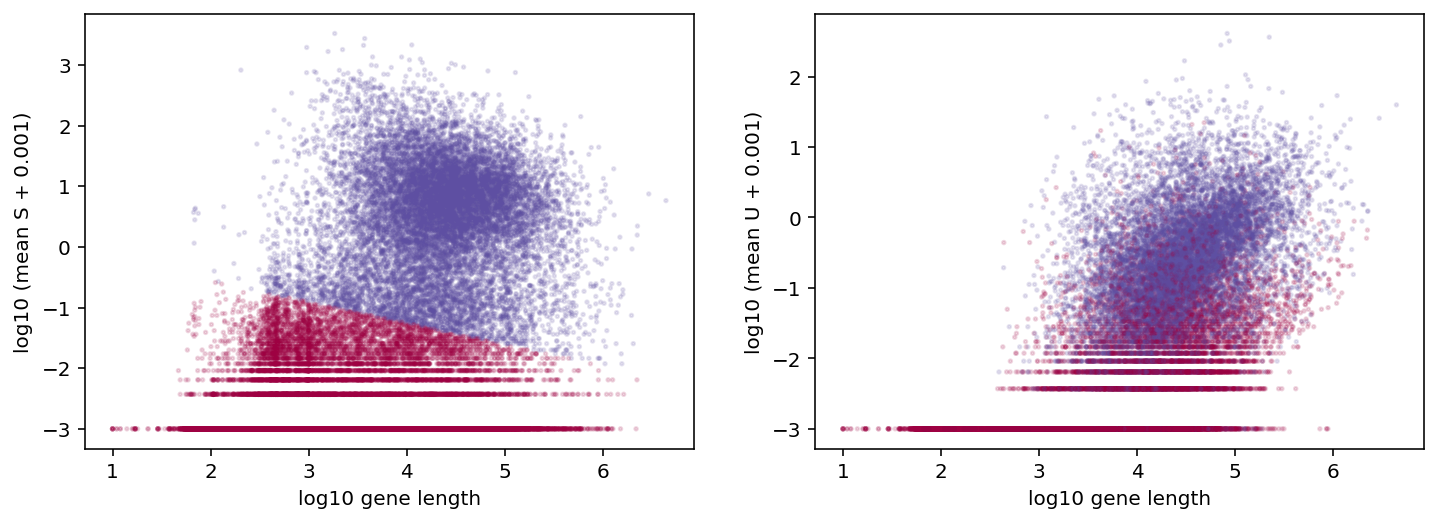

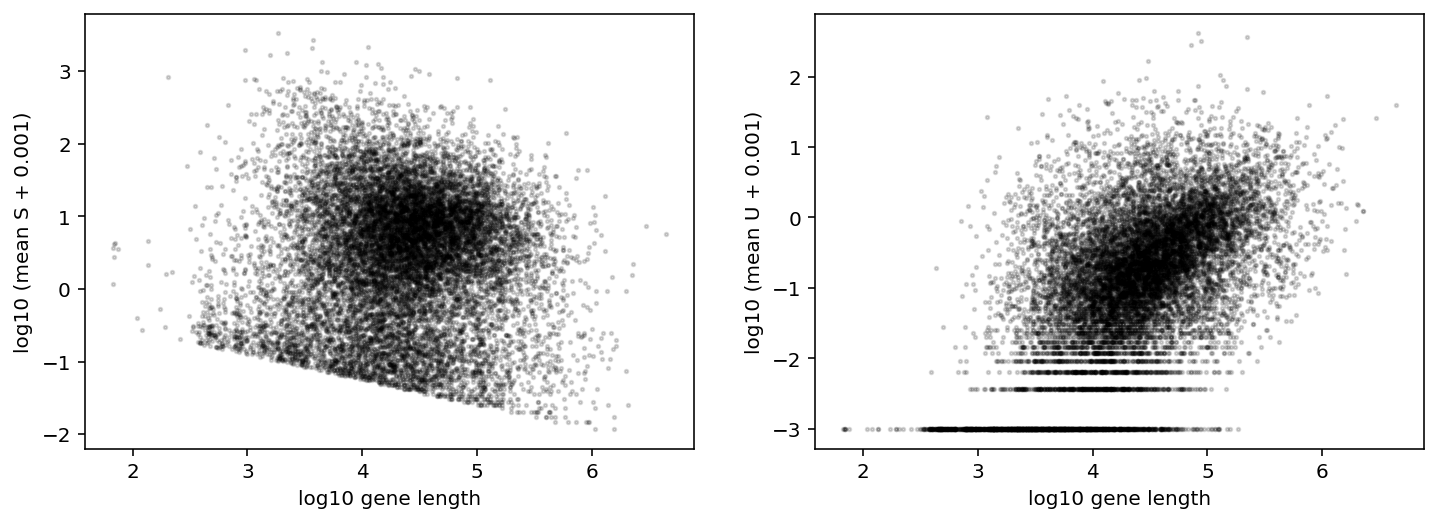

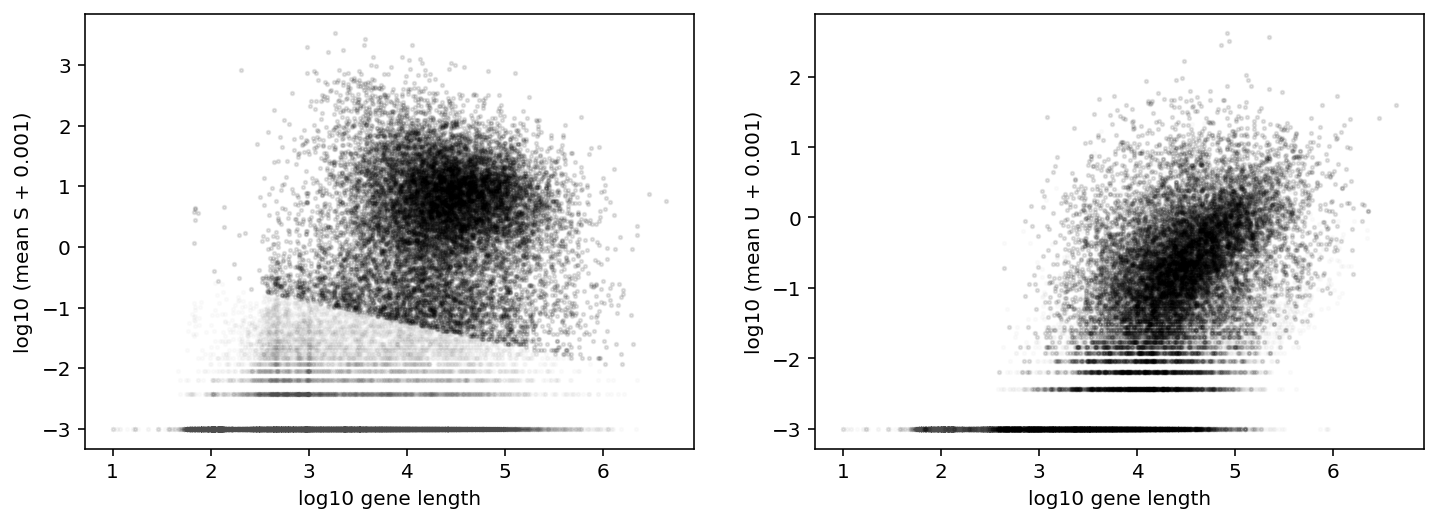

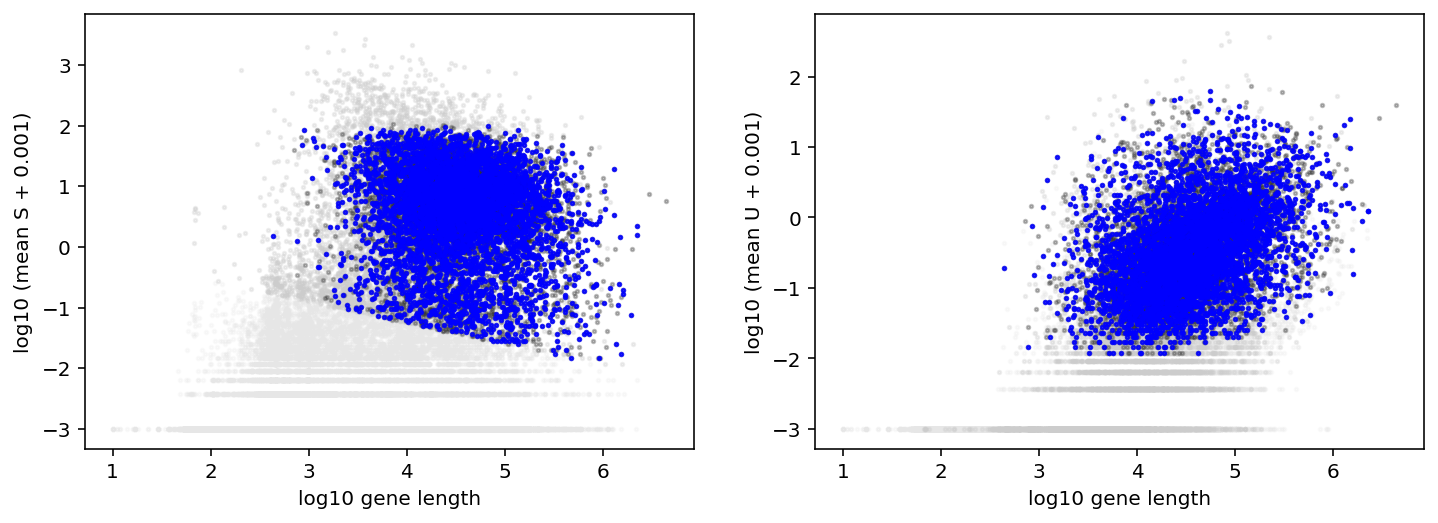

In [77]:
inference_workflow(smartseq_looms[0]+'_input.txt')
#output looks ok, clear separation between high and low count genes